# Demo of differentiable model for $\langle M_{\star}\vert M_{\rm halo}\rangle$

The model for the stellar-to-halo mass relation (SMHM) in the `differentiable_smhm` repo is a power law with a rolling index:

$$M_{\star} = M_0\cdot(M_{\rm halo}/M_{\rm crit})^{\alpha(M_{\rm halo})},$$

where $\alpha(M_{\rm halo})$ is a 4-parameter sigmoid function:
$$\alpha(M_{\rm halo}) \equiv \alpha_{\rm low} + \frac{\alpha_{\rm high} - \alpha_{\rm low}}{1 + \exp\left[-k\cdot(m-m_0)\right]},$$
where $m\equiv\log_{10}M_{\rm halo}.$


### Comment on subhalo/host halo nomenclature

In models based on subhalos and/or merger trees, all galaxies sit at the dead center of a (sub)halo; some (sub)halos are themselves distinct halos unto themselves, which we will call _host halos_; galaxies seated at the center of a host halo are _central galaxies_. Some (sub)halos are _subhalos_ that are bound within the virial radius of a more massive host halo; we will refer to such galaxies as _satellite galaxies_. Thus the term "(sub)halo" refers to the collection of subhalos and host halos. 

All properties of a galaxy in the real Universe are largely determined by the properties of the (sub)halo hosting the galaxy; this is even true for satellite galaxies, since the subhalos hosting satellites lead most of their lives as host halos, although of course it is true that for satellites there are important additional effects that come from the properties of the host halo. When we refer to quantities in a (sub)halo catalog such as maximum circular velocity, $V_{\rm max},$ it should be understood that we _always_ mean this to refer to the properties of the (sub)halo unless explicitly stated otherwise. For example, we will denote the mass of the host halo of a satellite by $M_{\rm host},$ whereas the variable $M_{\rm peak}$ refers to the peak historical mass of the (sub)halo hosting the galaxy. Thanks to this convention, we can usually get away with dropping the pedantic parentheses and just write/say "subhalo". We'll even stretch/abuse this convention so that when we write $M_{\rm halo},$ it should be understood that we are referring to the mass of the (sub)halo; again, whenever referring to host halo quantities, we will verbally or mathematically denote the quantities in a way that makes this explicit.

### Context and back story

The model in the `differentiable_smhm` repo is intended to apply to a catalog of (sub)halos at a single redshift. Matt and I originally developed this model in the early days of working out the math and computation underlying our differentiable modeling approach. We intended to apply this model to SDSS, but we never got around to doing the actual analysis. Part of the reason is that once we realized how powerful these differentiable modeling methods were, we got a lot more interested in pan-redshift multi-wavelength analyses. Many of the techniques in the `differentiable_smhm` repo ended up in the SHAMNet paper. It's probably fair to say that our main motivation for publishing SHAMNet was so that we could publish the material on the differentiable summary statistics; you can find those in the `diff_stats_cpu.py` module, though these demo notebooks won't cover that material. 

All the models in the repo are based on stitching together sigmoid functions in some way. The SMHM model demonstrated here is only a one-dimensional model: once you know $M_{\rm halo},$ you know $M_{\star}.$ The model in the `differentiable_smhm` repo for merging is also based on sigmoids, but it's a two-dimensional model: you need to know _both_ $M_{\rm host}$ _and_ $V_{\rm max}/V_{\rm peak}$ in order to know the probability that a subhalo merges with its host. Finally, the quenching model in the `differentiable_smhm` repo is three-dimensional. 

The `differentiable_smhm` repo includes a demo notebook for each of these three modeling ingredients. Since stitching sigmoids together to construct a multivariate differentiable fitting function is such a useful technical skill, it will be worth it to study how these models work in some detail, starting here with the SMHM and proceeding in order of complexity.

The quenching model implemented in this repo really only applies to single-redshift samples of galaxies that are either "quenched" or "not quenched", and so this ingredient is not very extensible to either pan-redshift or multi-wavelength analyses. In the diffdesi model, we'll rely on DiffstarPop to handle the quenching via a probability distribution for quenching times.

It's also true that the merging model implemented in `differentiable_smhm` was meant for single-redshift analyses, however this ingredient can be more naturally extended. After poring over these three notebooks, the next milestone will involve adapting the merging ingredients to work hand-in-hand with DiffstarPop across redshift.

### Warmup exercises

1. Fiddle around with the SMHM model parameters and remake the plot below to build intuition behind what each parameter does.
2. Check your intuitive understanding of the model parameters by reviewing the source code and ensuring that it makes good sense.
3. Make plots of the _gradients_ of the SMHM using `jax.grad`, and make sure that the plots of the gradients tell a story about the model that is consistent with story you get by just manually fiddling around with the parameters.
    - Remember that `jax.grad` wants to work with scalar-valued functions, so you may need to rewrite a few kernels to be scalar-valued, call `jax.grad` on your scalar-valued functions, and then use `jax.vmap` to vectorize your gradient computation.

In [1]:
from matplotlib import pyplot as plt
import numpy as np

In [2]:
from diffsmhm.galhalo_models import sigmoid_smhm

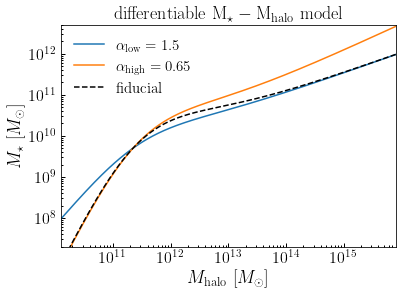

In [3]:
n_h = 1_000

logmp_plot = np.linspace(10.1, 15.9, n_h)

fig, ax = plt.subplots(1, 1)
__=ax.loglog()
ylim = ax.set_ylim(2e7, 5e12)
xlim = ax.set_xlim(10**logmp_plot.min(), 10**logmp_plot.max())

__=ax.plot(10**logmp_plot, 10**sigmoid_smhm.logsm_from_logmhalo(logmp_plot, smhm_lowm_index=1.5), 
           label=r'$\alpha_{\rm low}=1.5$')
__=ax.plot(10**logmp_plot, 10**sigmoid_smhm.logsm_from_logmhalo(logmp_plot, smhm_highm_index=0.65), 
           label=r'$\alpha_{\rm high}=0.65$')
__=ax.plot(10**logmp_plot, 10**sigmoid_smhm.logsm_from_logmhalo(logmp_plot), 
           '--', label=r'${\rm fiducial}$', color='k')

xlabel = ax.set_xlabel(r'$M_{\rm halo}\ [M_{\odot}]$')
ylabel = ax.set_ylabel(r'$M_{\star}\ [M_{\odot}]$')
title = ax.set_title(r'${\rm differentiable\ M_{\star}-M_{\rm halo}\ model}$')
leg = ax.legend()

fig.savefig('smhm_model_demo.png', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight', dpi=200) 

## Not-so-warmup exercises

Now try applying this model to a real life subhalo catalog. You can use any subhalo catalog you like, but this notebook shows how to use halotools to load the Bolshoi subhalo catalog into memory.

For the not-so-warmup, write a _differentiable_ function that calculates $\Phi_{\rm g}(m_{\star}),$ the stellar mass function (SMF) of a synthetic galaxy population, where $m_{\star}\equiv\log_{10}M_{\star},$ and the SMF is defined as the physical number density per Mpc$^3$ of galaxies in a logarithmic bin of stellar mass.

1. Use JAX to calculate $\Phi_{\rm g}(m_{\star}\vert\theta_{\rm fid}),$ where $\theta_{\rm fid}$ are the fiducial model parameters. Verify that you get exactly the same results
    - There is already a histogram function written in JAX, so that is an easy place to start. But this is a good opportunity to practice some JAX fundamentals, so try to write one yourself from scratch in which you write a scalar version of the histogram calculation, and then use vmap to vectorize it.
2. Use JAX to calculate $\partial\Phi_{\rm g}(m_{\star})/\partial\theta.$ Make a plot of these gradients and convince yourself that the results make physical sense based on the intuition you gained from the warmup exercises about the physical interpretation of the model parameters. 

In [4]:
from halotools.sim_manager import CachedHaloCatalog
halocat = CachedHaloCatalog()
halos = halocat.halo_table

In [5]:
# This cell shows how to extract the information from halotools that you need for the SMF calculation
scale_factor = 1/(1+halocat.redshift)
comoving_volume = np.prod(halocat.Lbox)
physical_volume = comoving_volume*(scale_factor**3)

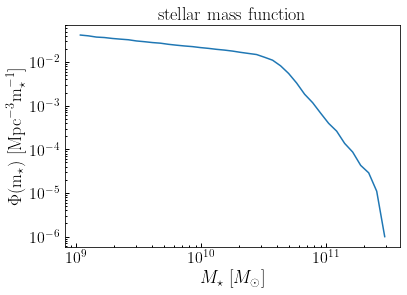

In [6]:
halos['logsm'] = sigmoid_smhm.logsm_from_logmhalo(np.log10(halos['halo_mpeak']))

logsm_bins = np.linspace(9, 11.5, 40)
logsm_binmids = 0.5*(logsm_bins[:-1] + logsm_bins[1:])
logsm_hist_counts = np.histogram(halos['logsm'], bins=logsm_bins)[0]
dlogsm = np.diff(logsm_bins)
smf = logsm_hist_counts / dlogsm / physical_volume

fig, ax = plt.subplots(1, 1)
__=ax.loglog()
__ = ax.plot(10**logsm_binmids, smf)
xlabel = ax.set_xlabel(r'$M_{\star}\ [M_{\odot}]$')
ylabel = ax.set_ylabel(r'$\Phi({\rm m}_{\star})\ {\rm [Mpc^{-3}m_{\star}^{-1}]}$')
title = ax.set_title(r'${\rm stellar\ mass\ function}$')